<a href="https://colab.research.google.com/github/StanleyLiangYork/2023_journal_club_CNN4N/blob/main/VAE_FasionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-probability
# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.4 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-guwmw1l3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-guwmw1l3
  Resolved https://github.com/tensorflow/docs to commit 4d512c2d7c40d69fcb842978aeaa136e19abe2bb
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=2fe5a1d7f93fdbc65935b583b7168d0c9b159f567822a5065f0d2cc7d250112a
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8sejvuq/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
from IPython import display
from IPython.display import clear_output
import os
from zipfile import ZipFile
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras import layers

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

AUTOTUNE = tf.data.AUTOTUNE

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  #improve contrast
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


# set the hyperparameters
train_size = 60000
batch_size = 32
test_size = 10000

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

Define the VAE model

In [6]:
# VAE cost function as negative ELBO (Evidence Lower Bound Objective)

def normal_log_pdf(sample, mean, sd, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  logvar = np.log((np.square(sd)))
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def vae_cost(x_true, model, analytic_kl=True, kl_weight=0.02):
  z_sample, mu, sd = model.encode(x_true)
  x_recons_logits = model.decoder(z_sample)
  # compute cross entropy loss for each dimension of every datapoint
  raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits) # bs*128*128*3
  # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,), the first term of the objective
  neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3]) # the first term of the objective

  # compute reverse KL divergence, either analytically or through MC approximation with one sample, the second term of the objective
  if analytic_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd), axis=1)  # shape=(batch_size, )
  else:
    logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
    logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
    kl_divergence = logqz_x - logpz
  elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
  return -elbo

In [21]:
# Adjust the KL divergence weight here
@tf.function
def train_step(x_true, model, optimizer, analytic_kl=True, kl_weight=0.1):
  with tf.GradientTape() as tape:
    cost_mini_batch = vae_cost(x_true, model, analytic_kl, kl_weight)
  gradients = tape.gradient(cost_mini_batch, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return cost_mini_batch

In [23]:
class Encoder_Z(tfk.layers.Layer):

    def __init__(self, dim_z, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=4, strides=(2, 2), padding='same')) # 14*14*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=64, kernel_size=4, strides=(2, 2), padding='same')) # 7*7*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Flatten())
        layers.append(tfkl.Dense(self.dim_z * 2,
                                 activation=None))  # *2 because number of parameters for both mean and (raw) standard deviation
        return tfk.Sequential(layers)

In [24]:
class Decoder_X(tfk.layers.Layer):

    def __init__(self, dim_z, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=(self.dim_z,))]
        layers.append(tfkl.Dense(7 * 7 * 16, activation=None))
        layers.append(tfkl.Reshape((7, 7, 16)))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same')) # 14*14*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')) # 28*28*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same'))  # 28*28*1

        return tfk.Sequential(layers)

In [25]:
class VAE(tfk.Model):

    def __init__(self, dim_z, learning_rate, seed=2000, name="autoencoder", **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.seed = seed
        self.encoder = Encoder_Z(dim_z=self.dim_z).build()
        self.decoder = Decoder_X(dim_z=self.dim_z).build()

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.dim_z))
      return self.decode(eps, apply_sigmoid=True)


    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1 + tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

In [26]:
autoencoder = VAE(64, 2e-4)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
def generate_and_save_images(model, epoch, test_sample):
  z, mean, logvar = model.encode(test_sample)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    plt.subplot(4, 4, i + 1)
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

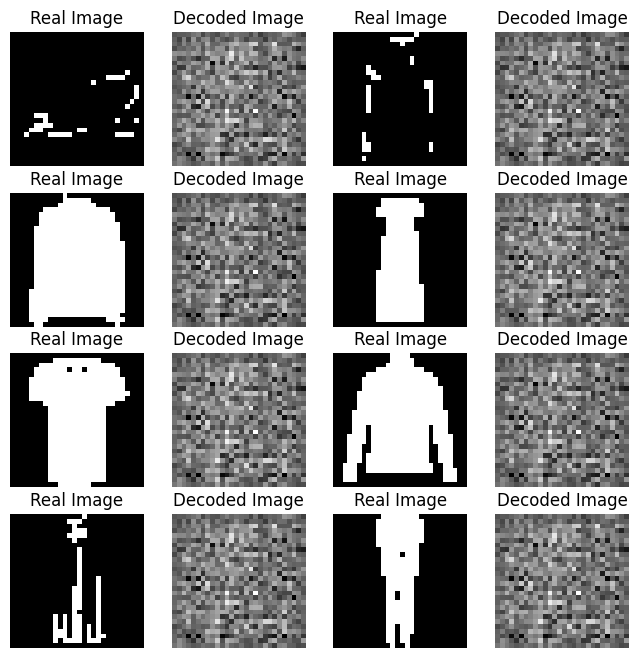

In [28]:
images = next(iter(test_dataset))
z, mean, logvar = autoencoder.encode(images)
predictions = autoencoder.sample(z)
fig = plt.figure(figsize=(8, 8))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  if i % 2 == 0:
    show_img = tf.keras.preprocessing.image.array_to_img(images[i, :, :, :])
    plt.title('Real Image')
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
  else:
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.title('Decoded Image')
    plt.imshow(show_img, cmap='gray')
    plt.axis(False)

Train the VAE

In [29]:
epochs = 15
images = next(iter(test_dataset))
test_sample = images

Epoch: 15, Test set ELBO: -61.15711212158203, time elapse for current epoch: 6.9058380126953125


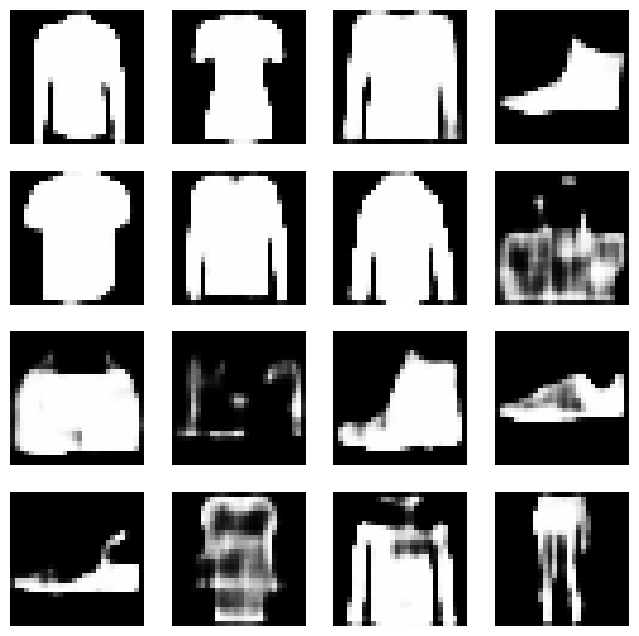

In [30]:
generate_and_save_images(autoencoder, 0, test_sample)
vae_history = dict()
vae_history['loss'] = []
vae_history['val_loss'] = []

for epoch in range(1, epochs + 1):

  start_time = time.time()
  loss = []
  for train_x in train_dataset:
    temp_loss = train_step(train_x, autoencoder, optimizer)
    loss.append(temp_loss)

  loss = np.array(loss)
  end_time = time.time()
  elbo = np.mean(loss)
  vae_history['loss'].append(elbo)
  print(f'epoch -- {epoch}: Loss: {elbo}')

  val_loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    val_loss(vae_cost(test_x, autoencoder))
  val_elbo = -val_loss.result()
  vae_history['val_loss'].append(val_elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, val_elbo, end_time - start_time))
  generate_and_save_images(autoencoder, epoch, test_sample)

Display a generated image from the last training epoch

In [31]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 799.5, 799.5, -0.5)

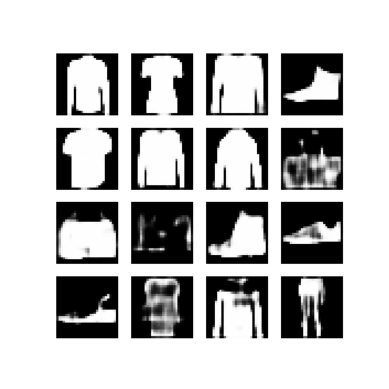

In [32]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [33]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-33-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-33-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



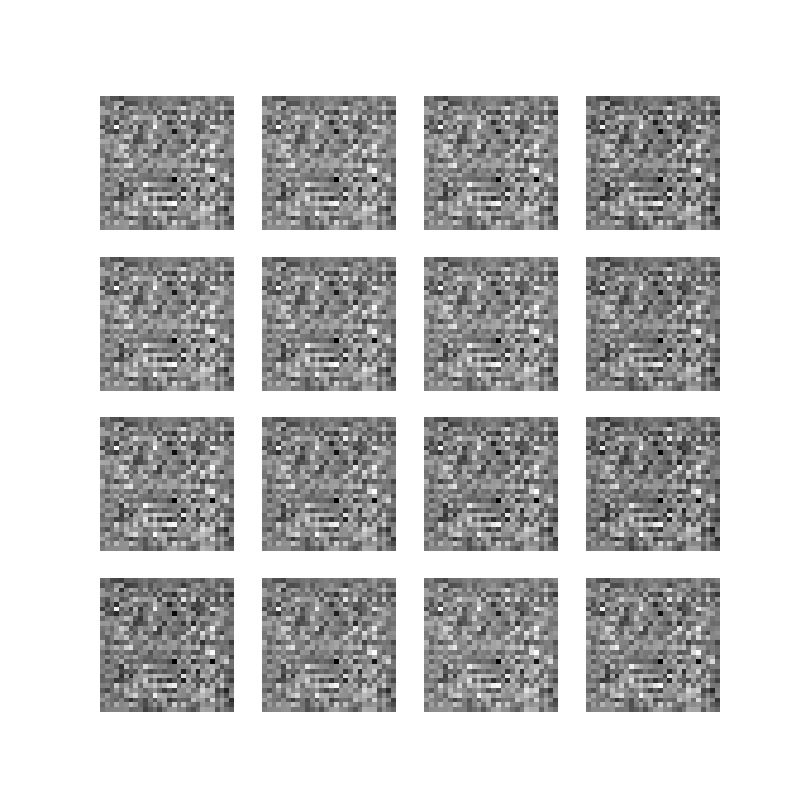

In [34]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)